In [1]:
## ---- Partition Cell Set Analysis - Extended Analysis 2 ---- 0550.00.00
## Load Analysis Parameters (Parm1)
## Loop Through Each Partition and Perform Analysis as Follows:
## Load Partition Cell Set
## Load Partition Differential Expresssion Gene Set Model
## Create Volcano Plots
## Create Special Volcano Plots for VSMC and EC Partitions
## Create Special Gene/Cell Plots for VSMC and EC Partitions
## Perform Other Plots as Needed

In [2]:
## Create a Working Input and Output Data Directory, If Id Does Not Exist
parentdir <- '/gpfs/group/torkamani/devans/'
datdir <- paste(parentdir, 'CDC2', sep = '')
if (!file.exists(datdir)) {
    dir.create(datdir)
}
setwd(datdir)

In [3]:
## Read the parameters file
ps <- read.table(file = 'parms.txt', stringsAsFactors = FALSE, header = TRUE)

In [5]:
## Load Monocle3 and Seurat Libraries
library(monocle3)
library(Seurat)
library(dplyr)
library(magrittr)
library(ggplot2)
library(gridExtra)
library(Matrix)
library(rhdf5)
library(grid)
library(EnhancedVolcano)

In [6]:
## Read the previously preprocessed downsampled cell set data object
down_stdycds <- readRDS(file = paste(ps$outdir,
                   'Aggregated.downsampled.QC.NoDoublets.Repartitioned.rds', sep = ''))

In [7]:
## Build a gene short name to gene id (Ensembl) lookup
short2geneid <- fData(down_stdycds)@rownames
names(short2geneid) <- fData(down_stdycds)@listData$gene_short_name

In [8]:
## Build a gene id (Ensembl) to gene short name lookup
geneid2short <- fData(down_stdycds)@listData$gene_short_name
names(geneid2short) <- fData(down_stdycds)@rownames

In [9]:
## Create variables for how cells sets are organized
cellgrps <- c('healthy', 'diseased', 'healthy', 'diseased', 'healthy', 'diseased')
cellpats <- c('ID Number 1', 'ID Number 1', 'ID Number 2', 'ID Number 2', 'ID Number 3', 'ID Number 3')

In [10]:
## Define and Assign Cell Types
celltypes6 <- c('1-Macrophages',
                '2-Endothelial Cells',
                '3-VSMCs',
                '4-Natural Killer Cells',
                '5-Cytotoxic T Lymphocytes',
                '6-B Lymphocytes')

In [11]:
## Declare Tom's best genes for definiting cell types
toms_markers5 <- c('NRXN1', 'CLU', 'ICAM2',
                 'CD14', 'CD68', 'AIF1',
                 'VWF', 'EDN1', 'ECSCR',
                 'MKI67', 'UBE2C', 'TOP2A',
                 'ACTA2', 'TAGLN', 'MYL9',
                 'ACKR1', 'SPARCL1', 'PECAM1',
                 'CALD1', 'MGP', 'DCN',
                 'NKG7', 'XCL1', 'CTSW',
                 'CD8A', 'TRAC', 'CD2',
                 'MS4A1', 'CD79A', 'BANK1',
                 'CD69', 'CXCR4', 'IL7R',
                 'LILRA4', 'IRF7', 'CLEC4C',
                 'MZB1', 'JCHAIN', 'TNFRSF17',
                 'LST1', 'FCGR3B', 'S100A8',
                 'TPSAB1', 'CPA3', 'MS4A2')
toms_gene_ids5 <- short2geneid[toms_markers5]


doug_markers1 <- c('AIF1', 'LYZ', 'FCER1G',  'CD68',
                'RNASE1', 'PECAM1', 'IGFBP4', 'ADIRF', 
                'SOD3', 'MYL9', 'CALD1', 'GSN',
                'TYROBP', 'NKG7', 'CTSW', 'CD69',
                'CD3D', 'CD2', 'TRBC2', 'TRAC',
                'MS4A1', 'CD79A', 'HLA-DQA1', 'CD37')
dougs_gene_ids1 <- short2geneid[doug_markers1]

In [12]:
## Loop through the partitions and perform volcano plots
np <- length(celltypes6)
ngenes <- 400
fxco <- rbind(c(1E-20, 0.25),
              c(1E-50, 0.25),
              c(1E-50, 0.25),
              c(1E-01,  0.25),
              c(1E-15, 0.25),
              c(1E-01, 0.25))

for (p in 1:np) {
    setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = ''))
    ## Extract partition subset for par
    if (file.exists('Diff.AllHealthCoeff.RemoveFail.NoModels.txt'))  {   
        de_tab <- read.table('Diff.AllHealthCoeff.RemoveFail.NoModels.txt', header = TRUE,
                             stringsAsFactors = FALSE)
    }
    ## Prepare cutoffs for two plots based on pvalues and Normalized Effect
    ne_abs <- abs(de_tab$normalized_effect)
    ne_abs_o <- order(ne_abs, decreasing = TRUE)
    ne_nbs_co <- ne_abs[ne_abs_o][ngenes * 2]
    de_tab_ne <- de_tab[(ne_abs >= ne_nbs_co),]
    ne_pv_co <- de_tab_ne[order(de_tab_ne$p_value,
                                decreasing = FALSE),]$p_value[ngenes]
    
    pv_abs <- abs(de_tab$p_value)
    pv_abs_o <- order(pv_abs, decreasing = FALSE)
    pv_nbs_co <- pv_abs[pv_abs_o][ngenes * 2]
    de_tab_pv <- de_tab[(pv_abs <= pv_nbs_co),]
    pv_ne_co <- abs(de_tab_pv[order(abs(de_tab_pv$normalized_effect),
                                    decreasing = TRUE),]$normalized_effect[ngenes])
    
    g1 <- EnhancedVolcano(de_tab,  lab = de_tab$gene_short_name,
            x = 'normalized_effect', y = 'q_value',
            xlim = c(-7, 7), pCutoff = ne_pv_co, FCcutoff = ne_nbs_co,
            xlab = "Normalized Effect", ylab = '-Log10(q_value)',
            legend = c("NS", "Norm. Effect", "q", "q & Norm. Effect"),
            title = paste('Volcano Plot for ', celltypes6[p],
                          '\nEmphasis: Normalized Effect', sep = ''))
        
    g2 <- EnhancedVolcano(de_tab,  lab = de_tab$gene_short_name,
            x = 'normalized_effect', y = 'q_value',
            xlim = c(-7, 7), pCutoff = pv_nbs_co, FCcutoff = pv_ne_co,
            xlab = "Normalized Effect", ylab = '-Log10(q_value)',
            legend = c("NS", "Norm. Effect", "q", "q & Norm. Effect"),
            title = paste('Volcano Plot for ', celltypes6[p], 
                          '\nEmphasis: q-Value', sep = ''))
    
    g3 <- EnhancedVolcano(de_tab,  lab = de_tab$gene_short_name,
            x = 'normalized_effect', y = 'q_value',
            xlim = c(-7, 7), pCutoff = fxco[p,1], FCcutoff = fxco[p,2],
            xlab = "Normalized Effect", ylab = '-Log10(q_value)',
            legend = c("NS", "Norm. Effect", "q", "q & Norm. Effect"),
            title = paste('Volcano Plot for ', celltypes6[p], 
                          '\nFixed Cutoffs', sep = ''))    
    
    plotfp <- 'Volcano.Plot.Emphasis.Normalized_Effect.Rev1.pdf'     
    pdf(plotfp, width = 10, height = 10)
        print(g1)
    dev.off()
    
    plotfp <- 'Volcano.Plot.Emphasis.q_Value.Rev1.pdf'     
    pdf(plotfp, width = 10, height = 10)
        print(g2)
    dev.off()
         
    plotfp <- 'Volcano.Plot.Fixed.Cutoffs.Rev1.pdf'     
    pdf(plotfp, width = 10, height = 10)
        print(g3)
    dev.off()
    }

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_point).”

In [260]:
## Loop through the VSMC partition and perform extended volcano plots
vsmc_genes <- c('SPP1', 'IBSP', 'POSTN', 'MMP11', 'RARRES1', 'EGR1', 'ZFP36',
                'APOLD1', 'JUN', 'FOS', 'JUNB', 'FOSB', 'TNFAIP2')

p = 3
setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = ''))
## Extract partition subset for par
if (file.exists('Diff.AllHealthCoeff.RemoveFail.NoModels.txt'))  {   
    de_tab <- read.table('Diff.AllHealthCoeff.RemoveFail.NoModels.txt', header = TRUE,
                         stringsAsFactors = FALSE)
}

## Remove the high q_value genes from de_tab
de_tab <- de_tab[(de_tab$q_value < 0.9999), ]
de_tab$logq <- -1/log10(de_tab$q_value)

g4 <- EnhancedVolcano(de_tab,  lab = de_tab$gene_short_name,
        x = 'normalized_effect', y = 'logq', selectLab = vsmc_genes,
        xlim = c(-7, 7), pCutoff = -1/log10(.05), FCcutoff = 1, ylim = c(0,2.5),
        xlab = "Normalized Effect", ylab = '-Log10(-1/logq)', transcriptLabSize = 1,
        legend = c("NS", "Norm. Effect", "q", "q & Norm. Effect"),
        title = paste('Volcano Plot for ', celltypes6[p],
                      '\nLog10(-1/Log10(q_value)) Select Genes', sep = ''))

g5 <- EnhancedVolcano(de_tab,  lab = de_tab$gene_short_name,
        x = 'normalized_effect', y = 'logq', transcriptLabSize = 3,
        xlim = c(-7, 7), pCutoff = -1/log10(.05), FCcutoff = 1, ylim = c(0,2.5),
        xlab = "Normalized Effect", ylab = '-Log10(-1/logq)',
        legend = c("NS", "Norm. Effect", "q", "q & Norm. Effect"),
        title = paste('Volcano Plot for ', celltypes6[p],
                      '\nLog10(-1/Log10(q_value)) All Gene', sep = ''))


plotfp <- 'Special.Volcano.Plot.Selected.Genes.LogLogq.Rev1.pdf'     
pdf(plotfp, width = 10, height = 10)
    print(g4)
dev.off()

plotfp <- 'Special.Volcano.Plot.AllNonZero.qvalue.Genes.LogLogq.Rev1.pdf'     
pdf(plotfp, width = 10, height = 10)
    print(g5)
dev.off()


Warning message:
“Removed 253 rows containing missing values (geom_point).”

png 
  2

Warning message:
“Removed 253 rows containing missing values (geom_point).”Warning message:
“Removed 2 rows containing missing values (geom_text).”

png 
  2

In [275]:
## Loop through the EC partition and perform extended volcano plots
ec_genes <- c('ITLN1', 'SCX', 'FN1', 'S100A4', 'FOS', 'IER2')

p = 2
setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = ''))
## Extract partition subset for par
if (file.exists('Diff.AllHealthCoeff.RemoveFail.NoModels.txt'))  {   
    de_tab <- read.table('Diff.AllHealthCoeff.RemoveFail.NoModels.txt', header = TRUE,
                         stringsAsFactors = FALSE)
}

## Remove the high q_value genes from de_tab
de_tab <- de_tab[(de_tab$q_value < 0.9999), ]
de_tab$logq <- -1/log10(de_tab$q_value)

g6 <- EnhancedVolcano(de_tab,  lab = de_tab$gene_short_name,
        x = 'normalized_effect', y = 'logq', selectLab = ec_genes,
        xlim = c(-7, 7), pCutoff = -1/log10(.05), FCcutoff = .2, ylim = c(0, 2.5),
        xlab = "Normalized Effect", ylab = '-Log10(-1/logq)', transcriptLabSize = 3,
        legend = c("NS", "Norm. Effect", "q", "q & Norm. Effect"),
        title = paste('Volcano Plot for ', celltypes6[p],
                      '\nLog10(-1/Log10(q_value)) Select Genes', sep = ''))

g7 <- EnhancedVolcano(de_tab,  lab = de_tab$gene_short_name,
        x = 'normalized_effect', y = 'logq', transcriptLabSize = 3,
        xlim = c(-7, 7), pCutoff = -1/log10(.05), FCcutoff = .2, ylim = c(0, 2.5),
        xlab = "Normalized Effect", ylab = '-Log10(-1/logq)',
        legend = c("NS", "Norm. Effect", "q", "q & Norm. Effect"),
        title = paste('Volcano Plot for ', celltypes6[p],
                      '\nLog10(-1/Log10(q_value)) All Gene', sep = ''))

plotfp <- 'Special.Volcano.Plot.Selected.Genes.LogLogq.Rev1.pdf'     
pdf(plotfp, width = 10, height = 10)
    print(g6)
dev.off()

plotfp <- 'Special.Volcano.Plot.AllNonZero.qvalue.Genes.LogLogq.Rev1.pdf'     
pdf(plotfp, width = 10, height = 10)
    print(g7)
dev.off()



Warning message:
“Removed 229 rows containing missing values (geom_point).”

png 
  2

Warning message:
“Removed 229 rows containing missing values (geom_point).”

png 
  2

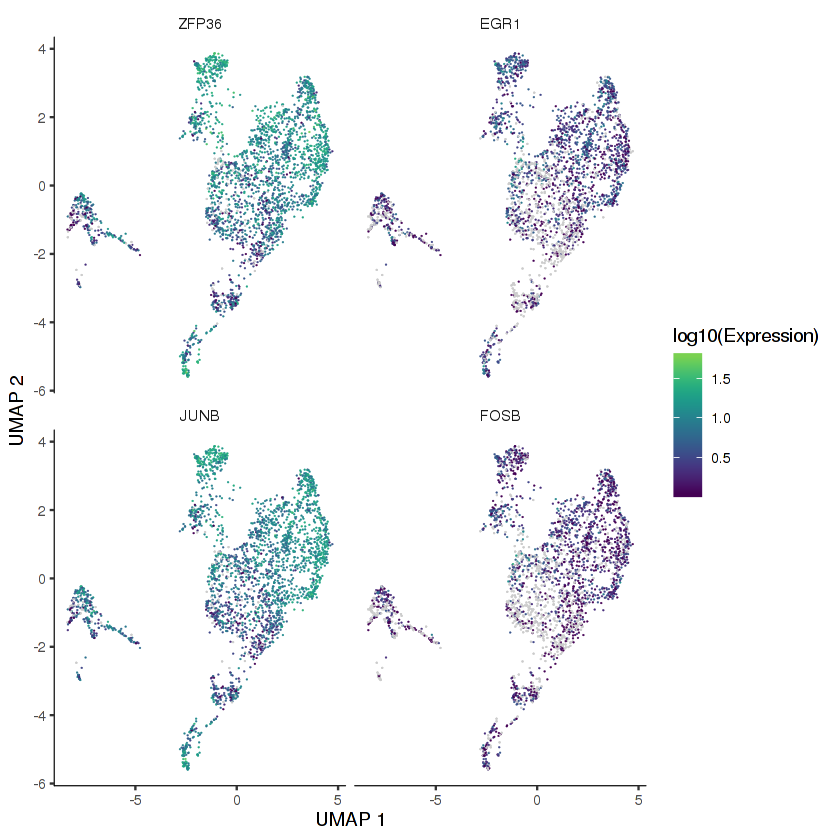

In [26]:
## Loop through the VSMC partition and import gene cell plots
vsmc_genes <- c('SPP1', 'IBSP', 'POSTN', 'MMP11', 'RARRES1', 'EGR1', 'ZFP36',
                'APOLD1', 'JUN', 'FOS', 'JUNB', 'FOSB', 'TNFAIP2')
vsmc_genes1 <- c('TIMP1', 'FN1', 'POSTN', 'COL4A1', 'SPP1')
vsmc_genes2 <- c('ZFP36', 'EGR1', 'JUNB', 'FOSB')


p = 3
setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = ''))
## Extract partition subset for par
# partn_cds <- readRDS('Partition.Cell.Set.rds')

g8 <- plot_cells(partn_cds, genes = vsmc_genes2,
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.2, alpha = .4)

plotfp <- 'Special.Genes.CellPlot.Rev1.pdf'     
# pdf(plotfp, width = 6, height = 6)
g8
# dev.off()

In [48]:
## Loop through the EC partition and import gene cell plots
ec_genes <- c('ITLN1', 'SCX', 'FN1', 'S100A4', 'FOS', 'IER2')
ec_genes1 <- c('IER2', 'FOS')
ec_genes2 <- c('FN1', 'TPM2', 'SERPINE2')
p = 2
setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = ''))
## Extract partition subset for par
partn_cds <- readRDS('Partition.Cell.Set.rds')

g8 <- plot_cells(partn_cds, genes = c(ec_genes1, ec_genes2),
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.2, alpha = .4)

plotfp <- 'Special.Genes.CellPlot.Rev1.pdf'     
pdf(plotfp, width = 6, height = 6)
g8
dev.off()

png 
  2

In [11]:
## Loop through the partitions and perform volcano plots
np <- length(celltypes6)
p <- 3
setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = ''))
## Extract partition subset for par
if (file.exists('Diff.AllHealthCoeff.RemoveFail.NoModels.txt'))  {   
    de_tab <- read.table('Diff.AllHealthCoeff.RemoveFail.NoModels.txt', header = TRUE,
                         stringsAsFactors = FALSE)
}

g10 <- EnhancedVolcano(de_tab,  lab = de_tab$gene_short_name, 
        x = 'normalized_effect', y = 'q_value',
        xlim = c(-7, 7), pCutoff = 1E-2, FCcutoff = 1,
        xlab = "Normalized Effect", ylab = '-Log10(q_value)',
        legend = c("NS", "Norm. Effect", "q", "q & Norm. Effect"),
        title = paste('Volcano Plot for ', celltypes6[p],
                      '\nCustomized Cutoffs', sep = ''))


plotfp <- 'Volcano.Plot.Customized.Cutoffs.Rev1.pdf'   
pdf(plotfp, width = 10, height = 10)
    print(g10)
dev.off()

In [80]:
## This plot was created in response to a reviewer comment. Changing the limits of the
## Plot allowed PLA2G2A and APOD to appear, but only the former was labelled with it's gene
## name. So the Rev2 pdf was edited and APOD was manually added and that became Rev2.1
wg1 <- which(de_tab$gene_short_name == "APOD")
wg2 <- which(substr(de_tab$gene_short_name, 1, 7) == "PLA2G2A")
small_tab <- cbind(de_tab[c(wg1, wg2), c(1, 7, 8, 10)], as.double(log10(de_tab$q_value[c(wg1, wg2)])))               
colnames(small_tab) <- c(colnames(small_tab)[1:4] , 'Log10(q_value)')
small_tab


g101 <- EnhancedVolcano(de_tab,  lab = de_tab$gene_short_name, # selectLab = c(wg2),
        x = 'normalized_effect', y = 'q_value',
        xlim = c(-8, 8), pCutoff = 1E-1, FCcutoff = 1,
        xlab = "Normalized Effect", ylab = '-Log10(q_value)',
        legend = c("NS", "Norm. Effect", "q", "q & Norm. Effect"),
        title = paste('Volcano Plot for ', celltypes6[p],
                      '\nCustomized Cutoffs', sep = ''))
plotfp <- 'Volcano.Plot.Customized.Cutoffs.Rev2.pdf'   
pdf(plotfp, width = 10, height = 10)
    print(g101)
dev.off()

,gene_short_name,p_value,normalized_effect,q_value,Log10(q_value)
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
4386,APOD,9.85e-07,7.730358,0.02291602,-1.639861
251,PLA2G2A,1.98e-06,7.253302,0.04593006,-1.337903


Warning message:
“Removed 1 rows containing missing values (geom_point).”


png 
  2

In [62]:
## These violin plots were created in support of a response to a review
## Set the partition to 3 - VSMC
p <- 3
setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = ''))
## Extract partition subset data
partn_cds <- readRDS('Partition.Cell.Set.rds')
## Set up genes to be plotted
nset1 <- c('ACTA2', 'CNN1', 'MYL9', 'TAGLN', 'TPM2', 'SOST', 'FLNA')
nset2 <- c('CALD1', 'MYL9', 'TAGLN')
## Create subsets
partn_cds_nset1 <- partn_cds[row.names(subset(rowData(partn_cds),
                 gene_short_name %in% nset1)),]
partn_cds_nset2 <- partn_cds[row.names(subset(rowData(partn_cds),
                 gene_short_name %in% nset2)),]

## Add PA and AC as alternatives to condition
cond_dis <- partn_cds_nset1$condition=="diseased"
partn_cds_nset1$condition <- c('PA', 'AC')[cond_dis + 1]
partn_cds_nset2$condition <- c('PA', 'AC')[cond_dis + 1]


## Setup and plot pdfs
# options(repr.plot.width=15, repr.plot.height=4)
g102 <- plot_genes_violin(partn_cds_nset1, group_cells_by="condition", ncol=7,
                  min_expr=0.1)
# options(repr.plot.width=8, repr.plot.height=4)
g103 <- plot_genes_violin(partn_cds_nset2, group_cells_by="condition", ncol=3,
                  min_expr=0.1)

plotfp102 <- 'Violin.Plot.VSMC.DiffExp.Special.Gene.Set1.Rev1.pdf'
pdf(plotfp102, width = 15, height = 4)
print(g102)
dev.off()

plotfp103 <- 'Violin.Plot.VSMC.DiffExp.Special.Gene.Set2.Rev1.pdf'
pdf(plotfp103, width = 7, height = 4)
print(g103)
dev.off()

Warning message in `[<-.factor`(`*tmp*`, is.na(cds_exprs$feature_label), value = structure(c(3L, :
“invalid factor level, NA generated”
Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message in `[<-.factor`(`*tmp*`, is.na(cds_exprs$feature_label), value = structure(c(3L, :
“invalid factor level, NA generated”
Warning message:
“`fun.y` is deprecated. Use `fun` instead.”


png 
  2

png 
  2

In [48]:
help(colData)

In [53]:
## Loop through the partitions and perform volcano plots
np <- length(celltypes6)
p <- 2
setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = ''))
## Extract partition subset for par
if (file.exists('Diff.AllHealthCoeff.RemoveFail.NoModels.txt'))  {   
    de_tab <- read.table('Diff.AllHealthCoeff.RemoveFail.NoModels.txt', header = TRUE,
                         stringsAsFactors = FALSE)
}

g11 <- EnhancedVolcano(de_tab,  lab = de_tab$gene_short_name,
        x = 'normalized_effect', y = 'q_value',
        xlim = c(-7, 7), pCutoff = 1E-2, FCcutoff = 1,
        xlab = "Normalized Effect", ylab = '-Log10(q_value)',
        legend = c("NS", "Norm. Effect", "q", "q & Norm. Effect"),
        title = paste('Volcano Plot for ', celltypes6[p],
                      '\nCustomized Cutoffs', sep = ''))


plotfp <- 'Volcano.Plot.Customized.Cutoffs.Rev1.pdf'     
pdf(plotfp, width = 10, height = 10)
    print(g11)
dev.off()

Warning message in grid.newpage():
“Cannot open temporary file '/scratch/RtmpDLhFSm/pdf1661e57740623' for compression (reason: No such file or directory); compression has been turned off for this device”

png 
  2

In [52]:
## Loop through the other partitions and perform volcano plots
np <- length(celltypes6)
for (p in c(1, 4, 5, 6)) {
    setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = ''))
    ## Extract partition subset for par
    if (file.exists('Diff.AllHealthCoeff.RemoveFail.NoModels.txt'))  {   
        de_tab <- read.table('Diff.AllHealthCoeff.RemoveFail.NoModels.txt', header = TRUE,
                             stringsAsFactors = FALSE)
    }

    g11 <- EnhancedVolcano(de_tab,  lab = de_tab$gene_short_name,
            x = 'normalized_effect', y = 'q_value',
            xlim = c(-7, 7), pCutoff = 1E-2, FCcutoff = 1,
            xlab = "Normalized Effect", ylab = '-Log10(q_value)',
            legend = c("NS", "Norm. Effect", "q", "q & Norm. Effect"),
            title = paste('Volcano Plot for ', celltypes6[p],
                          '\nCustomized Cutoffs', sep = ''))


    plotfp <- 'Volcano.Plot.Customized.Cutoffs.Rev1.pdf'     
    pdf(plotfp, width = 10, height = 10)
        print(g11)
    dev.off()
}

Warning message in grid.newpage():
“Cannot open temporary file '/scratch/RtmpDLhFSm/pdf1661e1d881dd7' for compression (reason: No such file or directory); compression has been turned off for this device”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message in grid.newpage():
“Cannot open temporary file '/scratch/RtmpDLhFSm/pdf1661e3b1f533' for compression (reason: No such file or directory); compression has been turned off for this device”Warning message in grid.newpage():
“Cannot open temporary file '/scratch/RtmpDLhFSm/pdf1661e6fd92868' for compression (reason: No such file or directory); compression has been turned off for this device”Warning message in grid.newpage():
“Cannot open temporary file '/scratch/RtmpDLhFSm/pdf1661e42d624c8' for compression (reason: No such file or directory); compression has been turned off for this device”

In [46]:
## Loop through the EC partition and import gene cell plots
vsmc_genes <- c('SPP1', 'IBSP', 'POSTN', 'MMP11', 'RARRES1', 'EGR1', 'ZFP36',
                'APOLD1', 'JUN', 'FOS', 'JUNB', 'FOSB', 'TNFAIP2')
vsmc_genes1 <- c('TIMP1', 'FN1', 'POSTN', 'COL4A1', 'SPP1')
vsmc_genes2 <- c('ZFP36', 'EGR1', 'JUNB', 'FOSB')

setwd(paste(datdir, '/', ps$outdir, sep = ''))

genes2plot <- unique(c(vsmc_genes1, vsmc_genes2))
g19 <- plot_cells(down_stdycds, genes = genes2plot,
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)

plotfp <- 'VSMC.Special.Genes.CellPlot.Rev2.pdf'     
pdf(plotfp, width = 20, height = 12)
g19
dev.off()

In [50]:
## Loop through the EC partition and import gene cell plots
ec_genes <- c('ITLN1', 'SCX', 'FN1', 'S100A4', 'FOS', 'IER2')
ec_genes1 <- c('IER2', 'FOS')
ec_genes2 <- c('FN1', 'TPM2', 'SERPINE2')
setwd(paste(datdir, '/', ps$outdir, sep = ''))

genes2plot <- unique(c(ec_genes1, ec_genes2))
g20 <- plot_cells(down_stdycds, genes = genes2plot,
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.2, alpha = .4)

plotfp <- 'EC.Special.Genes.CellPlot.Rev2.pdf'     
pdf(plotfp, width = 20, height = 10)
g20
dev.off()

png 
  2

In [1]:
monocle_theme_opts <- function()
{
  theme(strip.background = element_rect(colour = 'white', fill = 'white')) +
    theme(panel.border = element_blank()) +
    theme(axis.line.x = element_line(size=0.25, color="black")) +
    theme(axis.line.y = element_line(size=0.25, color="black")) +
    theme(panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank()) +
    theme(panel.grid.major.x = element_blank(),
          panel.grid.major.y = element_blank()) +
    theme(panel.background = element_rect(fill='white')) +
    theme(legend.key=element_blank())
}

plot_cells2 <- function(cds,
                       x=1,
                       y=2,
                       reduction_method = c("UMAP", "tSNE", "PCA", "LSI", "Aligned"),
                       color_cells_by="cluster",
                       group_cells_by=c("cluster", "partition"),
                       genes=NULL,
                       show_trajectory_graph=TRUE,
                       trajectory_graph_color="grey28",
                       trajectory_graph_segment_size=0.75,
                       norm_method = c("log", "size_only"),
                       label_cell_groups = TRUE,
                       label_groups_by_cluster=TRUE,
                       group_label_size=2,
                       labels_per_group=1,
                       label_branch_points=TRUE,
                       label_roots=TRUE,
                       label_leaves=TRUE,
                       graph_label_size=2,
                       cell_size=0.35,
                       cell_stroke= I(cell_size / 2),
                       alpha = 1,
                       min_expr=0.1,
                       rasterize=FALSE) {
  reduction_method <- match.arg(reduction_method)
  assertthat::assert_that(methods::is(cds, "cell_data_set"))
  assertthat::assert_that(!is.null(reducedDims(cds)[[reduction_method]]),
                          msg = paste("No dimensionality reduction for",
                                      reduction_method, "calculated.",
                                      "Please run reduce_dimensions with",
                                      "reduction_method =", reduction_method,
                                      "before attempting to plot."))
  low_dim_coords <- reducedDims(cds)[[reduction_method]]
  assertthat::assert_that(ncol(low_dim_coords) >=max(x,y),
                          msg = paste("x and/or y is too large. x and y must",
                                      "be dimensions in reduced dimension",
                                      "space."))
  if(!is.null(color_cells_by)) {
    assertthat::assert_that(color_cells_by %in% c("cluster", "partition",
                                                  "pseudotime") |
                              color_cells_by %in% names(colData(cds)),
                            msg = paste("color_cells_by must one of",
                                        "'cluster', 'partition', 'pseudotime,",
                                        "or a column in the colData table."))

    if(color_cells_by == "pseudotime") {
      tryCatch({pseudotime(cds, reduction_method = reduction_method)},
               error = function(x) {
                 stop(paste("No pseudotime for", reduction_method,
                            "calculated. Please run order_cells with",
                            "reduction_method =", reduction_method,
                            "before attempting to color by pseudotime."))})

    }
  }
  assertthat::assert_that(!is.null(color_cells_by) || !is.null(markers),
                          msg = paste("Either color_cells_by or markers must",
                                      "be NULL, cannot color by both!"))

  norm_method = match.arg(norm_method)
  group_cells_by=match.arg(group_cells_by)
  assertthat::assert_that(!is.null(color_cells_by) || !is.null(genes),
                          msg = paste("Either color_cells_by or genes must be",
                                      "NULL, cannot color by both!"))

  if (show_trajectory_graph &&
      is.null(principal_graph(cds)[[reduction_method]])) {
    message("No trajectory to plot. Has learn_graph() been called yet?")
    show_trajectory_graph = FALSE
  }

  gene_short_name <- NA
  sample_name <- NA
  #sample_state <- colData(cds)$State
  data_dim_1 <- NA
  data_dim_2 <- NA
  if (rasterize){
    plotting_func <- ggrastr::geom_point_rast
  }else{
    plotting_func <- ggplot2::geom_point
  }

  S_matrix <- reducedDims(cds)[[reduction_method]]
  data_df <- data.frame(S_matrix[,c(x,y)])

  colnames(data_df) <- c("data_dim_1", "data_dim_2")
  data_df$sample_name <- row.names(data_df)

  data_df <- as.data.frame(cbind(data_df, colData(cds)))
  if (group_cells_by == "cluster"){
    data_df$cell_group <-
      tryCatch({clusters(cds,
                         reduction_method = reduction_method)[
                           data_df$sample_name]},
               error = function(e) {NULL})
  } else if (group_cells_by == "partition") {
    data_df$cell_group <-
      tryCatch({partitions(cds,
                           reduction_method = reduction_method)[
                             data_df$sample_name]},
               error = function(e) {NULL})
  } else{
    stop("Error: unrecognized way of grouping cells.")
  }

  if (color_cells_by == "cluster"){
    data_df$cell_color <-
      tryCatch({clusters(cds,
                         reduction_method = reduction_method)[
                           data_df$sample_name]},
               error = function(e) {NULL})
  } else if (color_cells_by == "partition") {
    data_df$cell_color <-
      tryCatch({partitions(cds,
                           reduction_method = reduction_method)[
                             data_df$sample_name]},
               error = function(e) {NULL})
  } else if (color_cells_by == "pseudotime") {
    data_df$cell_color <-
      tryCatch({pseudotime(cds,
                           reduction_method = reduction_method)[
                             data_df$sample_name]}, error = function(e) {NULL})
  } else{
    data_df$cell_color <- colData(cds)[data_df$sample_name,color_cells_by]
  }

  ## Graph info
  if (show_trajectory_graph) {

    ica_space_df <- t(cds@principal_graph_aux[[reduction_method]]$dp_mst) %>%
      as.data.frame() %>%
      dplyr::select_(prin_graph_dim_1 = x, prin_graph_dim_2 = y) %>%
      dplyr::mutate(sample_name = rownames(.),
                    sample_state = rownames(.))

    dp_mst <- cds@principal_graph[[reduction_method]]

    edge_df <- dp_mst %>%
      igraph::as_data_frame() %>%
      dplyr::select_(source = "from", target = "to") %>%
      dplyr::left_join(ica_space_df %>%
                         dplyr::select_(
                           source="sample_name",
                           source_prin_graph_dim_1="prin_graph_dim_1",
                           source_prin_graph_dim_2="prin_graph_dim_2"),
                       by = "source") %>%
      dplyr::left_join(ica_space_df %>%
                         dplyr::select_(
                           target="sample_name",
                           target_prin_graph_dim_1="prin_graph_dim_1",
                           target_prin_graph_dim_2="prin_graph_dim_2"),
                       by = "target")
  }

  ## Marker genes
  markers_exprs <- NULL
  expression_legend_label <- NULL
  if (!is.null(genes)) {
    if (!is.null(dim(genes)) && dim(genes) >= 2){
      markers = unlist(genes[,1], use.names=FALSE)
    } else {
      markers = genes
    }
    markers_rowData <- as.data.frame(subset(rowData(cds),
                                            gene_short_name %in% markers |
                                              row.names(rowData(cds)) %in%
                                              markers))
    if (nrow(markers_rowData) == 0) {
      stop("None of the provided genes were found in the cds")
    }
    if (nrow(markers_rowData) >= 1) {
      cds_exprs <- SingleCellExperiment::counts(cds)[row.names(markers_rowData), ,drop=FALSE]
      cds_exprs <- Matrix::t(Matrix::t(cds_exprs)/size_factors(cds))

      if (!is.null(dim(genes)) && dim(genes) >= 2){
        genes = as.data.frame(genes)
        row.names(genes) = genes[,1]
        genes = genes[row.names(cds_exprs),]

        agg_mat = as.matrix(my.aggregate.Matrix(cds_exprs, as.factor(genes[,2]),
                                                fun="sum"))

        agg_mat = t(scale(t(log10(agg_mat + 1))))
        agg_mat[agg_mat < -2] = -2
        agg_mat[agg_mat > 2] = 2
        markers_exprs = agg_mat
        markers_exprs <- reshape2::melt(markers_exprs)
        colnames(markers_exprs)[1:2] <- c('feature_id','cell_id')
        if (is.factor(genes[,2]))
          markers_exprs$feature_id = factor(markers_exprs$feature_id,
                                            levels=levels(genes[,2]))

        markers_exprs$feature_label <- markers_exprs$feature_id
        norm_method = "size_only"
        expression_legend_label = "Expression score"
      } else {
        cds_exprs@x = round(cds_exprs@x)
        markers_exprs = matrix(cds_exprs, nrow=nrow(markers_rowData))
        colnames(markers_exprs) = colnames(SingleCellExperiment::counts(cds))
        row.names(markers_exprs) = row.names(markers_rowData)
        markers_exprs <- reshape2::melt(markers_exprs)
        colnames(markers_exprs)[1:2] <- c('feature_id','cell_id')
        markers_exprs <- merge(markers_exprs, markers_rowData,
                               by.x = "feature_id", by.y="row.names")
        if (is.null(markers_exprs$gene_short_name)) {
          markers_exprs$feature_label <-
            as.character(markers_exprs$feature_id)
        } else {
          markers_exprs$feature_label <-
            as.character(markers_exprs$gene_short_name)
        }

        markers_exprs$feature_label <- ifelse(is.na(markers_exprs$feature_label) | !as.character(markers_exprs$feature_label) %in% markers,
                                              as.character(markers_exprs$feature_id),
                                              as.character(markers_exprs$feature_label))

        markers_exprs$feature_label <- factor(markers_exprs$feature_label,
                                              levels = markers)
        if (norm_method == "size_only")
          expression_legend_label = "Expression"
        else
          expression_legend_label = "log10(Expression)"
      }
    }
  }

  if (label_cell_groups && is.null(color_cells_by) == FALSE){
    if (is.null(data_df$cell_color)){
      if (is.null(genes)){
        message(paste(color_cells_by, "not found in colData(cds), cells will",
                      "not be colored"))
      }
      text_df = NULL
      label_cell_groups = FALSE
    }else{
      if(is.character(data_df$cell_color) || is.factor(data_df$cell_color)) {

        if (label_groups_by_cluster && is.null(data_df$cell_group) == FALSE){
          text_df = data_df %>%
            dplyr::group_by(cell_group) %>%
            dplyr::mutate(cells_in_cluster= dplyr::n()) %>%
            dplyr::group_by(cell_color, add=TRUE) %>%
            dplyr::mutate(per=dplyr::n()/cells_in_cluster)
          median_coord_df = text_df %>%
            dplyr::summarize(fraction_of_group = dplyr::n(),
                             text_x = stats::median(x = data_dim_1),
                             text_y = stats::median(x = data_dim_2))
          text_df = suppressMessages(text_df %>% dplyr::select(per) %>%
                                       dplyr::distinct())
          text_df = suppressMessages(dplyr::inner_join(text_df,
                                                       median_coord_df))
          text_df = text_df %>% dplyr::group_by(cell_group) %>%
            dplyr::top_n(labels_per_group, per)
        } else {
          text_df = data_df %>% dplyr::group_by(cell_color) %>%
            dplyr::mutate(per=1)
          median_coord_df = text_df %>%
            dplyr::summarize(fraction_of_group = dplyr::n(),
                             text_x = stats::median(x = data_dim_1),
                             text_y = stats::median(x = data_dim_2))
          text_df = suppressMessages(text_df %>% dplyr::select(per) %>%
                                       dplyr::distinct())
          text_df = suppressMessages(dplyr::inner_join(text_df,
                                                       median_coord_df))
          text_df = text_df %>% dplyr::group_by(cell_color) %>%
            dplyr::top_n(labels_per_group, per)
        }

        text_df$label = as.character(text_df %>% dplyr::pull(cell_color))
        # I feel like there's probably a good reason for the bit below, but I
        # hate it and I'm killing it for now.
        # text_df$label <- paste0(1:nrow(text_df))
        # text_df$process_label <- paste0(1:nrow(text_df), '_',
        # as.character(as.matrix(text_df[, 1])))
        # process_label <- text_df$process_label
        # names(process_label) <- as.character(as.matrix(text_df[, 1]))
        # data_df[, group_by] <-
        #  process_label[as.character(data_df[, group_by])]
        # text_df$label = process_label
      } else {
        message(paste("Cells aren't colored in a way that allows them to",
                      "be grouped."))
        text_df = NULL
        label_cell_groups = FALSE
      }
    }
  }

  if (!is.null(markers_exprs) && nrow(markers_exprs) > 0){
    data_df <- merge(data_df, markers_exprs, by.x="sample_name",
                     by.y="cell_id")
    data_df$value <- with(data_df, ifelse(value >= min_expr, value, NA))
    na_sub <- data_df[is.na(data_df$value),]
    if(norm_method == "size_only"){
      g <- ggplot(data=data_df, aes(x=data_dim_1, y=data_dim_2)) +
        plotting_func(aes(data_dim_1, data_dim_2), size=I(cell_size),
                      stroke = I(cell_stroke), color = "grey80", alpha = alpha,
                      data = na_sub) +
        plotting_func(aes(color=value), size=I(cell_size),
                      stroke = I(cell_stroke), na.rm = TRUE) +
        viridis::scale_color_viridis(option = "viridis",
                                     name = expression_legend_label,
                                     na.value = "grey80", end = 0.8,
                                     alpha = alpha) +
        guides(alpha = FALSE) + facet_wrap(~feature_label)
    } else {
      g <- ggplot(data=data_df, aes(x=data_dim_1, y=data_dim_2)) +
        plotting_func(aes(data_dim_1, data_dim_2), size=I(cell_size),
                      stroke = I(cell_stroke), color = "grey80",
                      data = na_sub, alpha = alpha) +
        plotting_func(aes(color=log10(value+min_expr)),
                      size=I(cell_size), stroke = I(cell_stroke),
                      na.rm = TRUE, alpha = alpha) +
        viridis::scale_color_viridis(option = "viridis",
                                     name = expression_legend_label,
                                     na.value = "grey80", end = 0.8,
                                     alpha = alpha) +
        guides(alpha = FALSE) + facet_wrap(~feature_label)
    }
  } else {
    g <- ggplot(data=data_df, aes(x=data_dim_1, y=data_dim_2))

    # We don't want to force users to call order_cells before even being able
    # to look at the trajectory, so check whether it's null and if so, just
    # don't color the cells
    if(color_cells_by %in% c("cluster", "partition")){
      if (is.null(data_df$cell_color)){
        g <- g + geom_point(color=I("gray"), size=I(cell_size),
                            stroke = I(cell_stroke), na.rm = TRUE,
                            alpha = I(alpha))
        message(paste("cluster_cells() has not been called yet, can't",
                      "color cells by cluster"))
      } else{
        g <- g + geom_point(aes(color = cell_color), size=I(cell_size),
                            stroke = I(cell_stroke), na.rm = TRUE,
                            alpha = alpha)
      }
      g <- g + guides(color = guide_legend(title = color_cells_by,
                                           override.aes = list(size = 4)))
    } else if (class(data_df$cell_color) == "numeric"){
      g <- g + geom_point(aes(color = cell_color), size=I(cell_size),
                          stroke = I(cell_stroke), na.rm = TRUE, alpha = alpha)
      g <- g + viridis::scale_color_viridis(name = color_cells_by, option="C")
    } else {
      g <- g + geom_point(aes(color = cell_color), size=I(cell_size),
                          stroke = I(cell_stroke), na.rm = TRUE, alpha = alpha)
      g <- g + guides(color = guide_legend(title = color_cells_by,
                                           override.aes = list(size = 4)))
    }

  }
  if (show_trajectory_graph){
    g <- g + geom_segment(aes_string(x="source_prin_graph_dim_1",
                                     y="source_prin_graph_dim_2",
                                     xend="target_prin_graph_dim_1",
                                     yend="target_prin_graph_dim_2"),
                          size=trajectory_graph_segment_size,
                          color=I(trajectory_graph_color),
                          linetype="solid",
                          na.rm=TRUE,
                          data=edge_df)


    if (label_branch_points){
      mst_branch_nodes <- branch_nodes(cds)
      branch_point_df <- ica_space_df %>%
        dplyr::slice(match(names(mst_branch_nodes), sample_name)) %>%
        dplyr::mutate(branch_point_idx = seq_len(dplyr::n()))

      g <- g +
        geom_point(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2"),
                   shape = 21, stroke=I(trajectory_graph_segment_size),
                   color="white",
                   fill="black",
                   size=I(graph_label_size * 1.5),
                   na.rm=TRUE, branch_point_df) +
        geom_text(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2",
                             label="branch_point_idx"),
                  size=I(graph_label_size), color="white", na.rm=TRUE,
                  branch_point_df)
    }

    if (label_leaves){
      mst_leaf_nodes <- leaf_nodes(cds)
      leaf_df <- ica_space_df %>%
        dplyr::slice(match(names(mst_leaf_nodes), sample_name)) %>%
        dplyr::mutate(leaf_idx = seq_len(dplyr::n()))

      g <- g +
        geom_point(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2"),
                   shape = 21, stroke=I(trajectory_graph_segment_size),
                   color="black",
                   fill="lightgray",
                   size=I(graph_label_size * 1.5),
                   na.rm=TRUE,
                   leaf_df) +
        geom_text(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2",
                             label="leaf_idx"),
                  size=I(graph_label_size), color="black", na.rm=TRUE, leaf_df)
    }

    if (label_roots){
      mst_root_nodes <- root_nodes(cds)
      root_df <- ica_space_df %>%
        dplyr::slice(match(names(mst_root_nodes), sample_name)) %>%
        dplyr::mutate(root_idx = seq_len(dplyr::n()))

      g <- g +
        geom_point(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2"),
                   shape = 21, stroke=I(trajectory_graph_segment_size),
                   color="black",
                   fill="white",
                   size=I(graph_label_size * 1.5),
                   na.rm=TRUE,
                   root_df) +
        geom_text(aes_string(x="prin_graph_dim_1", y="prin_graph_dim_2",
                             label="root_idx"),
                  size=I(graph_label_size), color="black", na.rm=TRUE, root_df)
    }
  }

  if(label_cell_groups) {
    g <- g + ggrepel::geom_text_repel(data = text_df,
                                      mapping = aes_string(x = "text_x",
                                                           y = "text_y",
                                                           label = "label"),
                                      size=I(group_label_size))
    # If we're coloring by gene expression, don't hide the legend
    if (is.null(markers_exprs))
      g <- g + theme(legend.position="none")
  }

  g <- g +
    #scale_color_brewer(palette="Set1") +
    monocle_theme_opts() +
    xlab(paste(reduction_method, x)) +
    ylab(paste(reduction_method, y)) +
    #guides(color = guide_legend(label.position = "top")) +
    theme(legend.key = element_blank()) +
    theme(panel.background = element_rect(fill='white'))
  g
}
